In [1]:
# import the required packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

## 1. HR Analytics

### 1.1 Load and Explore the data

In [2]:
# Load the full dataset
df_data = pd.read_csv('hr_data.csv')


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
<class 'panda

In [4]:
# numeric data
df_data_num = df_data.select_dtypes(['int64', 'float64']).copy()
df_data_num.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0


In [5]:
# categorical data
df_data_cat = df_data.select_dtypes(['object']).copy()
df_data_cat.head()                       

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


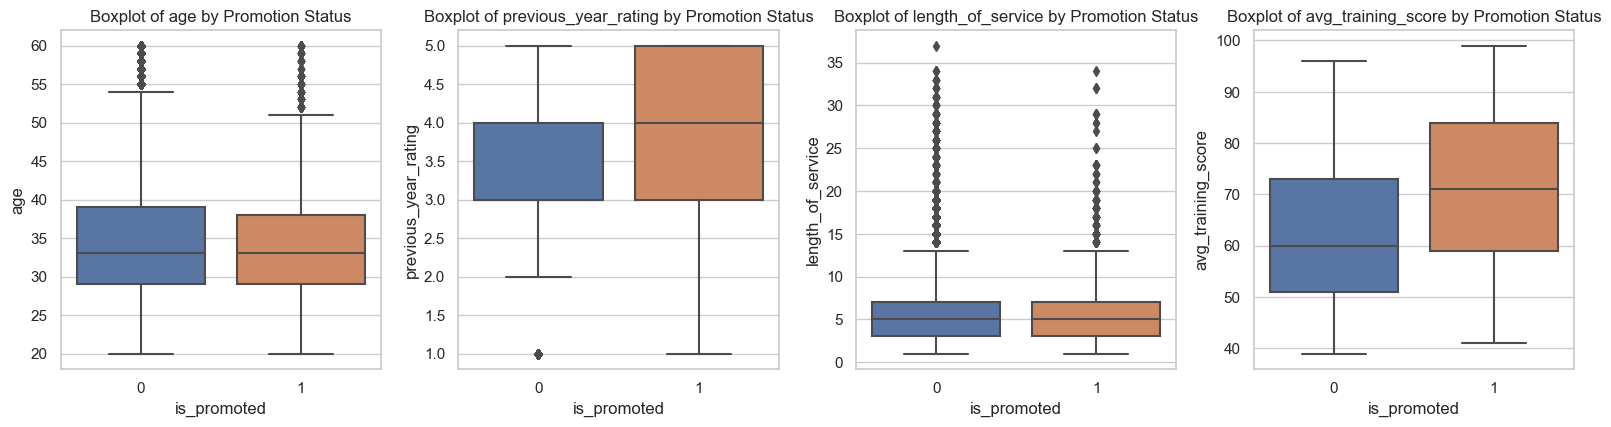

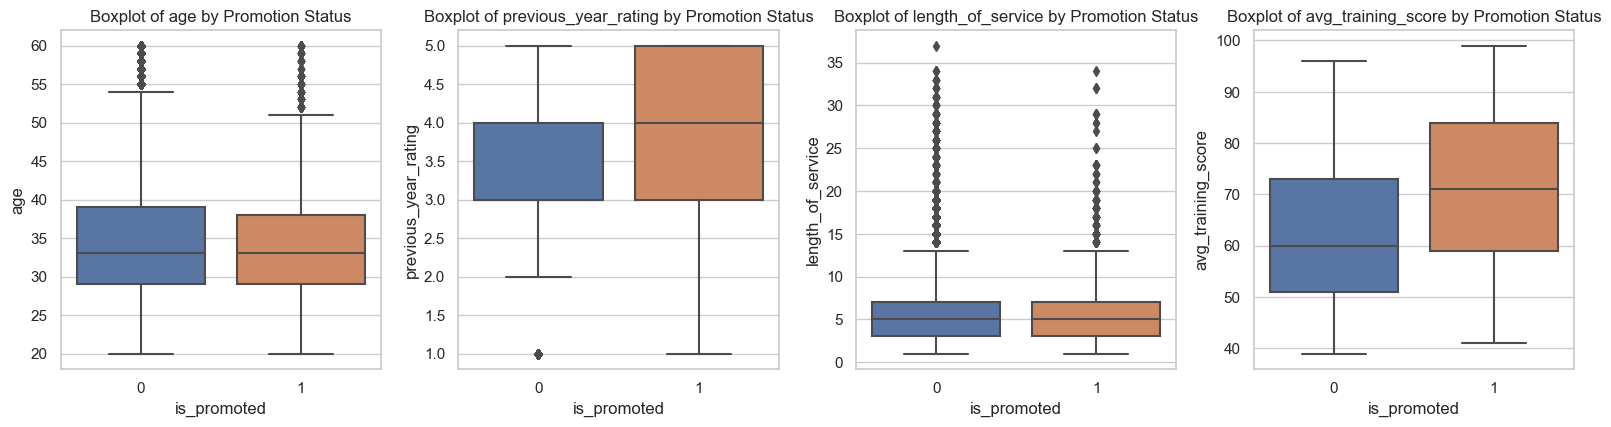

In [6]:

# Set the style for better aesthetics
sns.set(style="whitegrid")

# Select numerical and binary features along with the target variable
features = ['is_promoted', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']
df_selected_features = df_data[features]

# Create side-by-side boxplots for numerical and binary features
plt.figure(figsize=(16, 8))

# Boxplots for numerical features and binary features
for i, feature in enumerate(features[1:]):  # Exclude 'is_promoted'l
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='is_promoted', y=feature, data=df_selected_features)
    plt.title(f'Boxplot of {feature} by Promotion Status')

plt.tight_layout()
plt.show()


### 1.2 Cleanse and Transform the data

### 1.2.1 Missing Values

In [7]:
df_data.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
# Cleaning "Education" Column
df_data['education'].fillna('Unknown', inplace=True)  # Fill missing values with 'Unknown'
df_data['education'] = df_data['education'].str.lower()  # Standardize categories to lowercase

# Cleaning "Previous Year Rating" Column
df_data['previous_year_rating'].fillna(df_data['previous_year_rating'].median(), inplace=True)  # Impute missing values with the median
df_data['previous_year_rating'] = df_data['previous_year_rating'].astype(int)  # Ensure correct data type


In [9]:
df_data.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

#### Outliers

In [10]:
# Assuming df_data is your DataFrame
age_column = df_data['age']
length_of_service_column = df_data['length_of_service']

# Function to calculate outliers
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

# Count outliers for age
outliers_count_age = count_outliers(age_column)

# Count outliers for length_of_service
outliers_count_length_of_service = count_outliers(length_of_service_column)

# Total number of rows
total_rows = len(df_data)

# Print the results
print(f"Number of outliers in 'age': {outliers_count_age}")
print(f"Number of outliers in 'length_of_service': {outliers_count_length_of_service}")
print(f"Total number of rows: {total_rows}")
print(f"Percentage of outliers in 'age': {100 * outliers_count_age / total_rows:.2f}%")
print(f"Percentage of outliers in 'length_of_service': {100 * outliers_count_length_of_service / total_rows:.2f}%")


Number of outliers in 'age': 1435
Number of outliers in 'length_of_service': 3489
Total number of rows: 54808
Percentage of outliers in 'age': 2.62%
Percentage of outliers in 'length_of_service': 6.37%
Number of outliers in 'age': 1435
Number of outliers in 'length_of_service': 3489
Total number of rows: 54808
Percentage of outliers in 'age': 2.62%
Percentage of outliers in 'length_of_service': 6.37%


In [11]:
# Assuming df_data is your DataFrame
# For 'age'
Q1_age = df_data['age'].quantile(0.25)
Q3_age = df_data['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Remove rows with outliers in 'age'
df_data = df_data[(df_data['age'] >= lower_bound_age) & (df_data['age'] <= upper_bound_age)]

# For 'length_of_service'
Q1_service = df_data['length_of_service'].quantile(0.25)
Q3_service = df_data['length_of_service'].quantile(0.75)
IQR_service = Q3_service - Q1_service
lower_bound_service = Q1_service - 1.5 * IQR_service
upper_bound_service = Q3_service + 1.5 * IQR_service

# Remove rows with outliers in 'length_of_service'
df_data = df_data[(df_data['length_of_service'] >= lower_bound_service) & (df_data['length_of_service'] <= upper_bound_service)]

df_data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000
mean,39182.225084,1.260229,33.491757,3.304843,5.035343,0.359577,0.024056,63.496659,0.086677
std,22577.963815,0.614856,6.192374,1.212867,2.886381,0.479881,0.153225,13.452907,0.281364
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19692.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39160.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58729.750000,1.000000,37.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,54.000000,5.000000,13.000000,1.000000,1.000000,99.000000,1.000000


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000
mean,39182.225084,1.260229,33.491757,3.304843,5.035343,0.359577,0.024056,63.496659,0.086677
std,22577.963815,0.614856,6.192374,1.212867,2.886381,0.479881,0.153225,13.452907,0.281364
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19692.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39160.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58729.750000,1.000000,37.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,54.000000,5.000000,13.000000,1.000000,1.000000,99.000000,1.000000


### 1.2.2 Feature Engineering

#### Drop the irrelevant features/ columns

In [12]:
# Drop the 'employee_id','region','gender','department','recruitment_channel' columns
df_data = df_data.drop(['employee_id','region','gender'], axis = 1)
df_data.head()

,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,master's & above,sourcing,1,35,5,8,1,0,49,0
1,Operations,bachelor's,other,1,30,5,4,0,0,60,0
2,Sales & Marketing,bachelor's,sourcing,1,34,3,7,0,0,50,0
3,Sales & Marketing,bachelor's,other,2,39,1,10,0,0,50,0
4,Technology,bachelor's,other,1,45,3,2,0,0,73,0


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,master's & above,sourcing,1,35,5,8,1,0,49,0
1,Operations,bachelor's,other,1,30,5,4,0,0,60,0
2,Sales & Marketing,bachelor's,sourcing,1,34,3,7,0,0,50,0
3,Sales & Marketing,bachelor's,other,2,39,1,10,0,0,50,0
4,Technology,bachelor's,other,1,45,3,2,0,0,73,0


#### Create New Features

In [13]:
# Create new feature
df_data['training_effectiveness'] = df_data['avg_training_score'] / df_data['no_of_trainings']

# Display the first few rows of the DataFrame
df_data.head()


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
0,Sales & Marketing,master's & above,sourcing,1,35,5,8,1,0,49,0,49.0
1,Operations,bachelor's,other,1,30,5,4,0,0,60,0,60.0
2,Sales & Marketing,bachelor's,sourcing,1,34,3,7,0,0,50,0,50.0
3,Sales & Marketing,bachelor's,other,2,39,1,10,0,0,50,0,25.0
4,Technology,bachelor's,other,1,45,3,2,0,0,73,0,73.0


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
0,Sales & Marketing,master's & above,sourcing,1,35,5,8,1,0,49,0,49.0
1,Operations,bachelor's,other,1,30,5,4,0,0,60,0,60.0
2,Sales & Marketing,bachelor's,sourcing,1,34,3,7,0,0,50,0,50.0
3,Sales & Marketing,bachelor's,other,2,39,1,10,0,0,50,0,25.0
4,Technology,bachelor's,other,1,45,3,2,0,0,73,0,73.0


### 1.2.3 Data transformation

#### Encode Categorical Data Columns

In [14]:
unique = df_data['education'].unique()
unique

array(["master's & above", "bachelor's", 'unknown', 'below secondary'],
      dtype=object)

array(["master's & above", "bachelor's", 'unknown', 'below secondary'],
      dtype=object)

In [15]:
unique = df_data['department'].unique()
unique

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

In [16]:
unique = df_data['recruitment_channel'].unique()
unique

array(['sourcing', 'other', 'referred'], dtype=object)

array(['sourcing', 'other', 'referred'], dtype=object)

In [17]:
# education
df_data['education'] = df_data['education'].map( {"bachelor's": 0, 'below secondary': 1,"master's & above": 2,"unknown": 3} ).astype(int)
    

In [18]:
# recruitment_channel
df_data['recruitment_channel'] = df_data['recruitment_channel'].map( {"sourcing": 0, 'other': 1,"referred": 2} ).astype(int)

In [19]:
department_mapping = {department: idx for idx, department in enumerate(df_data['department'].unique())}

# Apply the mapping to encode the 'department' column
df_data['department'] = df_data['department'].map(department_mapping).astype(int)



In [20]:
df_data.head()

,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
0,0,2,0,1,35,5,8,1,0,49,0,49.0
1,1,0,1,1,30,5,4,0,0,60,0,60.0
2,0,0,0,1,34,3,7,0,0,50,0,50.0
3,0,0,1,2,39,1,10,0,0,50,0,25.0
4,2,0,1,1,45,3,2,0,0,73,0,73.0


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
0,0,2,0,1,35,5,8,1,0,49,0,49.0
1,1,0,1,1,30,5,4,0,0,60,0,60.0
2,0,0,0,1,34,3,7,0,0,50,0,50.0
3,0,0,1,2,39,1,10,0,0,50,0,25.0
4,2,0,1,1,45,3,2,0,0,73,0,73.0


#### Transform the Numeric Data Columns

In [21]:
df_data.describe()  

,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
count,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000
mean,2.232358,0.659636,0.598063,1.260229,33.491757,3.304843,5.035343,0.359577,0.024056,63.496659,0.086677,56.540950
std,2.293329,1.002737,0.532912,0.614856,6.192374,1.212867,2.886381,0.479881,0.153225,13.452907,0.281364,18.215224
min,0.000000,0.000000,0.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,4.900000
25%,0.000000,0.000000,0.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,47.000000
50%,1.000000,0.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,57.000000
75%,4.000000,2.000000,1.000000,1.000000,37.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,70.000000
max,8.000000,3.000000,2.000000,10.000000,54.000000,5.000000,13.000000,1.000000,1.000000,99.000000,1.000000,99.000000


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness
count,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000,50590.000000
mean,2.232358,0.659636,0.598063,1.260229,33.491757,3.304843,5.035343,0.359577,0.024056,63.496659,0.086677,56.540950
std,2.293329,1.002737,0.532912,0.614856,6.192374,1.212867,2.886381,0.479881,0.153225,13.452907,0.281364,18.215224
min,0.000000,0.000000,0.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,4.900000
25%,0.000000,0.000000,0.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,47.000000
50%,1.000000,0.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,57.000000
75%,4.000000,2.000000,1.000000,1.000000,37.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,70.000000
max,8.000000,3.000000,2.000000,10.000000,54.000000,5.000000,13.000000,1.000000,1.000000,99.000000,1.000000,99.000000


In [22]:
import numpy as np

# Define conditions and corresponding values
conditions = [
    (df_data['training_effectiveness'] <= 20),
    (df_data['training_effectiveness'] > 20) & (df_data['training_effectiveness'] <= 40),
    (df_data['training_effectiveness'] > 40) & (df_data['training_effectiveness'] <= 60),
    (df_data['training_effectiveness'] > 60) & (df_data['training_effectiveness'] <= 80),
    (df_data['training_effectiveness'] > 80)
]

values = [0, 1, 2, 3, 4]

# Create a new column based on conditions
df_data['training_effectiveness_level'] = np.select(conditions, values, default=5)

# Convert the new column to integer type
df_data['training_effectiveness_level'] = df_data['training_effectiveness_level'].astype(int)


In [23]:
df_data.head()

,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
0,0,2,0,1,35,5,8,1,0,49,0,49.0,2
1,1,0,1,1,30,5,4,0,0,60,0,60.0,2
2,0,0,0,1,34,3,7,0,0,50,0,50.0,2
3,0,0,1,2,39,1,10,0,0,50,0,25.0,1
4,2,0,1,1,45,3,2,0,0,73,0,73.0,3


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
0,0,2,0,1,35,5,8,1,0,49,0,49.0,2
1,1,0,1,1,30,5,4,0,0,60,0,60.0,2
2,0,0,0,1,34,3,7,0,0,50,0,50.0,2
3,0,0,1,2,39,1,10,0,0,50,0,25.0,1
4,2,0,1,1,45,3,2,0,0,73,0,73.0,3


In [24]:
effectiveness_counts = df_data['training_effectiveness_level'].value_counts()
print(effectiveness_counts)

training_effectiveness_level
2    23097
3    12784
1     6753
4     6622
0     1334
Name: count, dtype: int64
training_effectiveness_level
2    23097
3    12784
1     6753
4     6622
0     1334
Name: count, dtype: int64


### 1.3 Correlation Analysis

In [25]:
df_data.corr()

,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
department,1.000000,-0.046538,0.009749,-0.008425,-0.065042,0.056253,-0.058648,0.054103,0.004625,0.334328,0.000892,0.220272,0.210125
education,-0.046538,1.000000,-0.011836,-0.043158,0.228673,0.003138,0.140123,-0.016245,0.000286,-0.024386,0.009283,0.016962,0.016833
recruitment_channel,0.009749,-0.011836,1.000000,0.003590,-0.004939,0.021184,-0.008640,0.018987,0.006090,0.013243,0.003361,0.004164,0.001011
no_of_trainings,-0.008425,-0.043158,0.003590,1.000000,-0.074735,-0.063491,-0.046728,-0.048023,-0.008959,0.042787,-0.027321,-0.692699,-0.647577
age,-0.065042,0.228673,-0.004939,-0.074735,1.000000,0.036668,0.527220,0.006695,0.002782,-0.045053,-0.007583,0.029368,0.017738
previous_year_rating,0.056253,0.003138,0.021184,-0.063491,0.036668,1.000000,0.035860,0.336044,0.027018,0.072789,0.154384,0.079509,0.073660
length_of_service,-0.058648,0.140123,-0.008640,-0.046728,0.527220,0.035860,1.000000,-0.052945,-0.032762,-0.032508,0.003213,0.014811,0.008095
KPIs_met >80%,0.054103,-0.016245,0.018987,-0.048023,0.006695,0.336044,-0.052945,1.000000,0.097692,0.077235,0.220809,0.079653,0.069033
awards_won?,0.004625,0.000286,0.006090,-0.008959,0.002782,0.027018,-0.032762,0.097692,1.000000,0.071601,0.196476,0.055637,0.050039
avg_training_score,0.334328,-0.024386,0.013243,0.042787,-0.045053,0.072789,-0.032508,0.077235,0.071601,1.000000,0.179485,0.605673,0.605106


,department,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
department,1.000000,-0.046538,0.009749,-0.008425,-0.065042,0.056253,-0.058648,0.054103,0.004625,0.334328,0.000892,0.220272,0.210125
education,-0.046538,1.000000,-0.011836,-0.043158,0.228673,0.003138,0.140123,-0.016245,0.000286,-0.024386,0.009283,0.016962,0.016833
recruitment_channel,0.009749,-0.011836,1.000000,0.003590,-0.004939,0.021184,-0.008640,0.018987,0.006090,0.013243,0.003361,0.004164,0.001011
no_of_trainings,-0.008425,-0.043158,0.003590,1.000000,-0.074735,-0.063491,-0.046728,-0.048023,-0.008959,0.042787,-0.027321,-0.692699,-0.647577
age,-0.065042,0.228673,-0.004939,-0.074735,1.000000,0.036668,0.527220,0.006695,0.002782,-0.045053,-0.007583,0.029368,0.017738
previous_year_rating,0.056253,0.003138,0.021184,-0.063491,0.036668,1.000000,0.035860,0.336044,0.027018,0.072789,0.154384,0.079509,0.073660
length_of_service,-0.058648,0.140123,-0.008640,-0.046728,0.527220,0.035860,1.000000,-0.052945,-0.032762,-0.032508,0.003213,0.014811,0.008095
KPIs_met >80%,0.054103,-0.016245,0.018987,-0.048023,0.006695,0.336044,-0.052945,1.000000,0.097692,0.077235,0.220809,0.079653,0.069033
awards_won?,0.004625,0.000286,0.006090,-0.008959,0.002782,0.027018,-0.032762,0.097692,1.000000,0.071601,0.196476,0.055637,0.050039
avg_training_score,0.334328,-0.024386,0.013243,0.042787,-0.045053,0.072789,-0.032508,0.077235,0.071601,1.000000,0.179485,0.605673,0.605106


In [26]:
correlation_matrix = df_data.corr()
correlation_with_target = correlation_matrix['is_promoted'].sort_values(ascending=False)
correlation_with_target

is_promoted                     1.000000
KPIs_met >80%                   0.220809
awards_won?                     0.196476
avg_training_score              0.179485
previous_year_rating            0.154384
training_effectiveness          0.139526
training_effectiveness_level    0.132714
education                       0.009283
recruitment_channel             0.003361
length_of_service               0.003213
department                      0.000892
age                            -0.007583
no_of_trainings                -0.027321
Name: is_promoted, dtype: float64

is_promoted                     1.000000
KPIs_met >80%                   0.220809
awards_won?                     0.196476
avg_training_score              0.179485
previous_year_rating            0.154384
training_effectiveness          0.139526
training_effectiveness_level    0.132714
education                       0.009283
recruitment_channel             0.003361
length_of_service               0.003213
department                      0.000892
age                            -0.007583
no_of_trainings                -0.027321
Name: is_promoted, dtype: float64

In [27]:
# Drop the weak correlation columns
df_data = df_data.drop(['education','recruitment_channel','length_of_service','department','age','no_of_trainings'], axis = 1)
df_data.head()

,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
0,5,1,0,49,0,49.0,2
1,5,0,0,60,0,60.0,2
2,3,0,0,50,0,50.0,2
3,1,0,0,50,0,25.0,1
4,3,0,0,73,0,73.0,3


,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,training_effectiveness,training_effectiveness_level
0,5,1,0,49,0,49.0,2
1,5,0,0,60,0,60.0,2
2,3,0,0,50,0,50.0,2
3,1,0,0,50,0,25.0,1
4,3,0,0,73,0,73.0,3


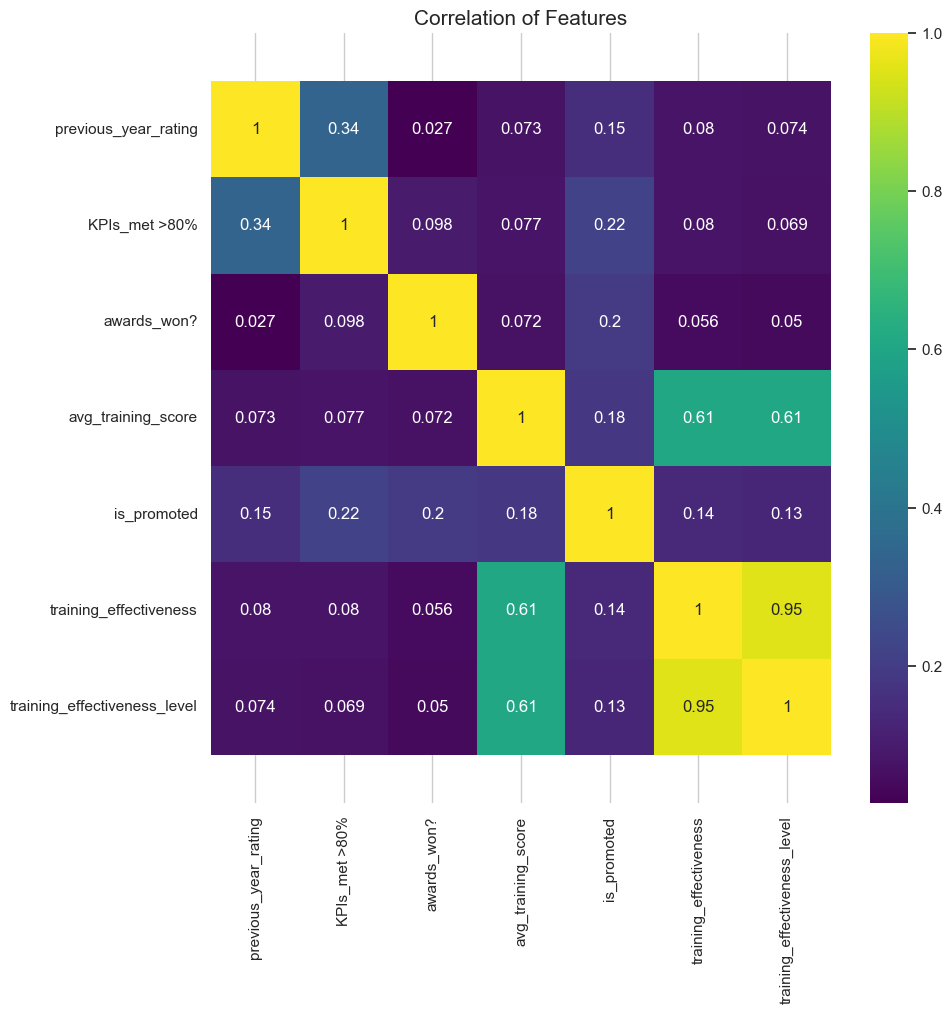

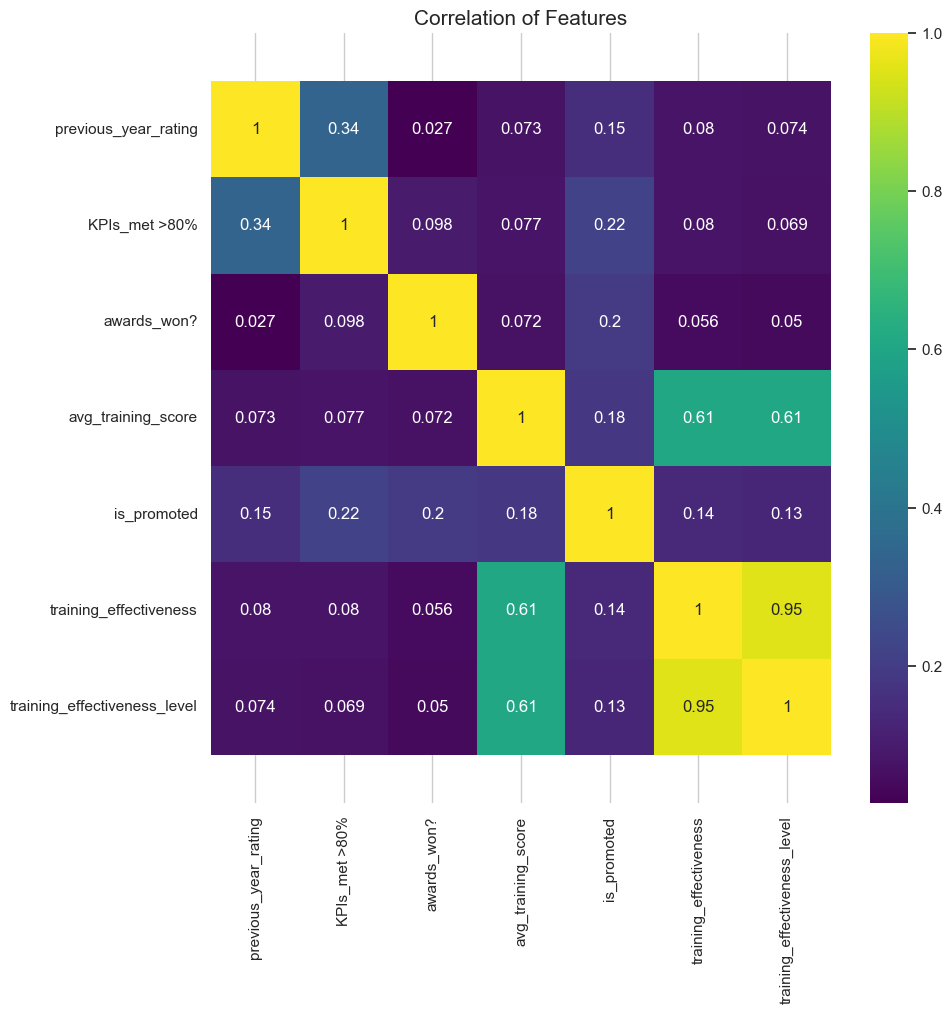

In [28]:
# Heatmap: the correlation between any two features/variables
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Correlation of Features', size=15)
ax = sns.heatmap(df_data.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### 1.4 Export the data

In [29]:
df_data.to_csv('hr_data_new.csv', index=False)

## 2. Airbnb

### 2.1 Load and Explore the data

In [30]:
df_listings = pd.read_csv('listings.csv')

In [31]:
# numeric data
df_num_listings = df_listings.select_dtypes(['int64', 'float64']).copy()
df_num_listings.head()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,266763,1.44255,103.79580,83,180,1,0.01,2,365
1,50646,227796,1.33235,103.78521,81,90,18,0.28,1,365
2,56334,266763,1.44246,103.79667,69,6,20,0.20,2,365
3,71609,367042,1.34541,103.95712,206,1,14,0.15,9,353
4,71896,367042,1.34567,103.95963,94,1,22,0.22,9,355


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,266763,1.44255,103.79580,83,180,1,0.01,2,365
1,50646,227796,1.33235,103.78521,81,90,18,0.28,1,365
2,56334,266763,1.44246,103.79667,69,6,20,0.20,2,365
3,71609,367042,1.34541,103.95712,206,1,14,0.15,9,353
4,71896,367042,1.34567,103.95963,94,1,22,0.22,9,355


In [32]:
# categorical data
df_cat_listings = df_listings.select_dtypes(['object']).copy()
df_cat_listings.head()

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review
0,COZICOMFORT LONG TERM STAY ROOM 2,Francesca,North Region,Woodlands,Private room,2013-10-21
1,Pleasant Room along Bukit Timah,Sujatha,Central Region,Bukit Timah,Private room,2014-12-26
2,COZICOMFORT,Francesca,North Region,Woodlands,Private room,2015-10-01
3,Ensuite Room (Room 1 & 2) near EXPO,Belinda,East Region,Tampines,Private room,2019-08-11
4,B&B Room 1 near Airport & EXPO,Belinda,East Region,Tampines,Private room,2019-07-28


,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review
0,COZICOMFORT LONG TERM STAY ROOM 2,Francesca,North Region,Woodlands,Private room,2013-10-21
1,Pleasant Room along Bukit Timah,Sujatha,Central Region,Bukit Timah,Private room,2014-12-26
2,COZICOMFORT,Francesca,North Region,Woodlands,Private room,2015-10-01
3,Ensuite Room (Room 1 & 2) near EXPO,Belinda,East Region,Tampines,Private room,2019-08-11
4,B&B Room 1 near Airport & EXPO,Belinda,East Region,Tampines,Private room,2019-07-28


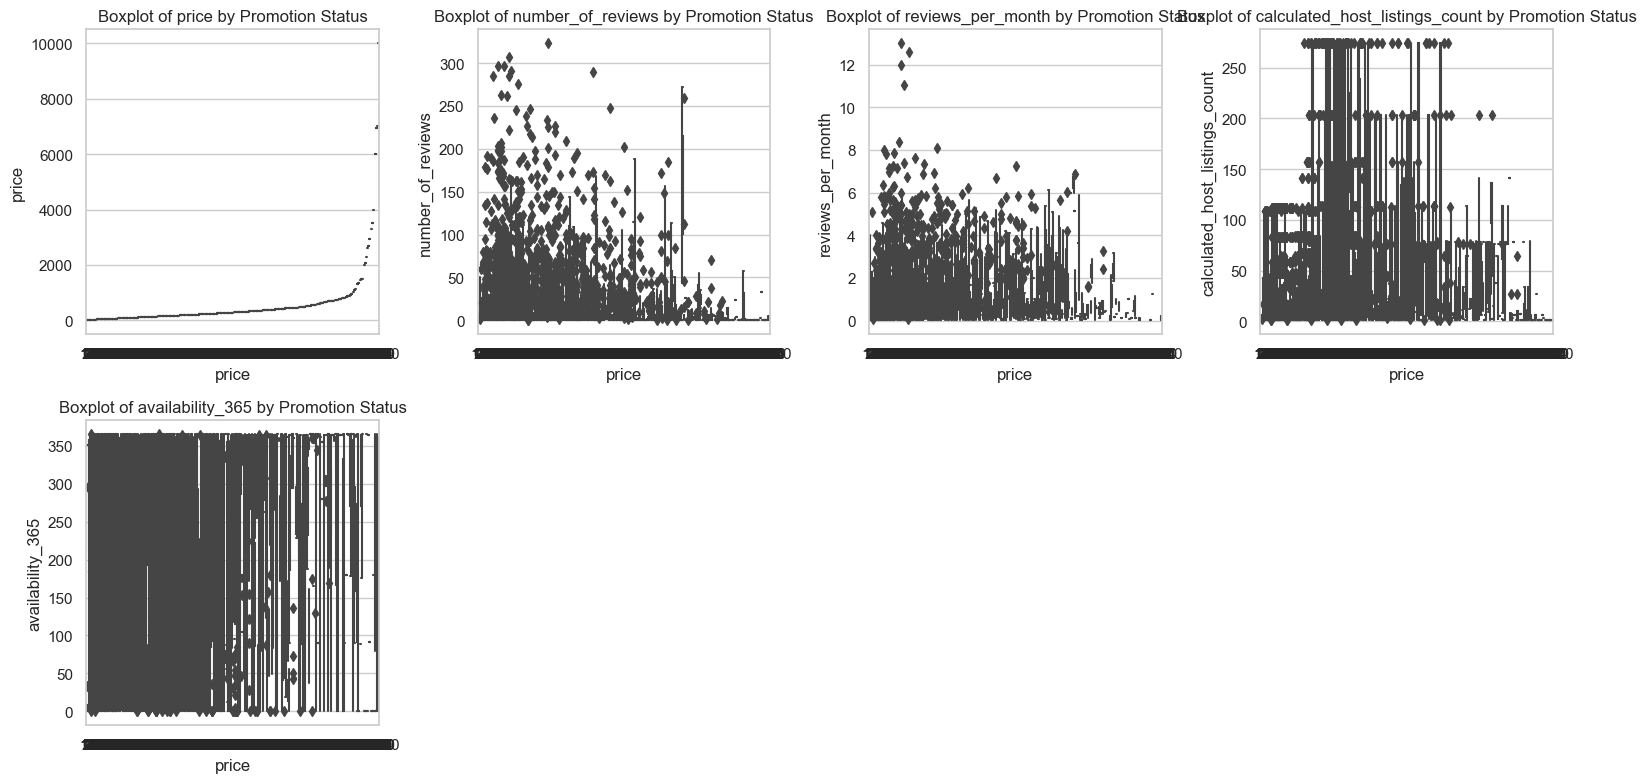

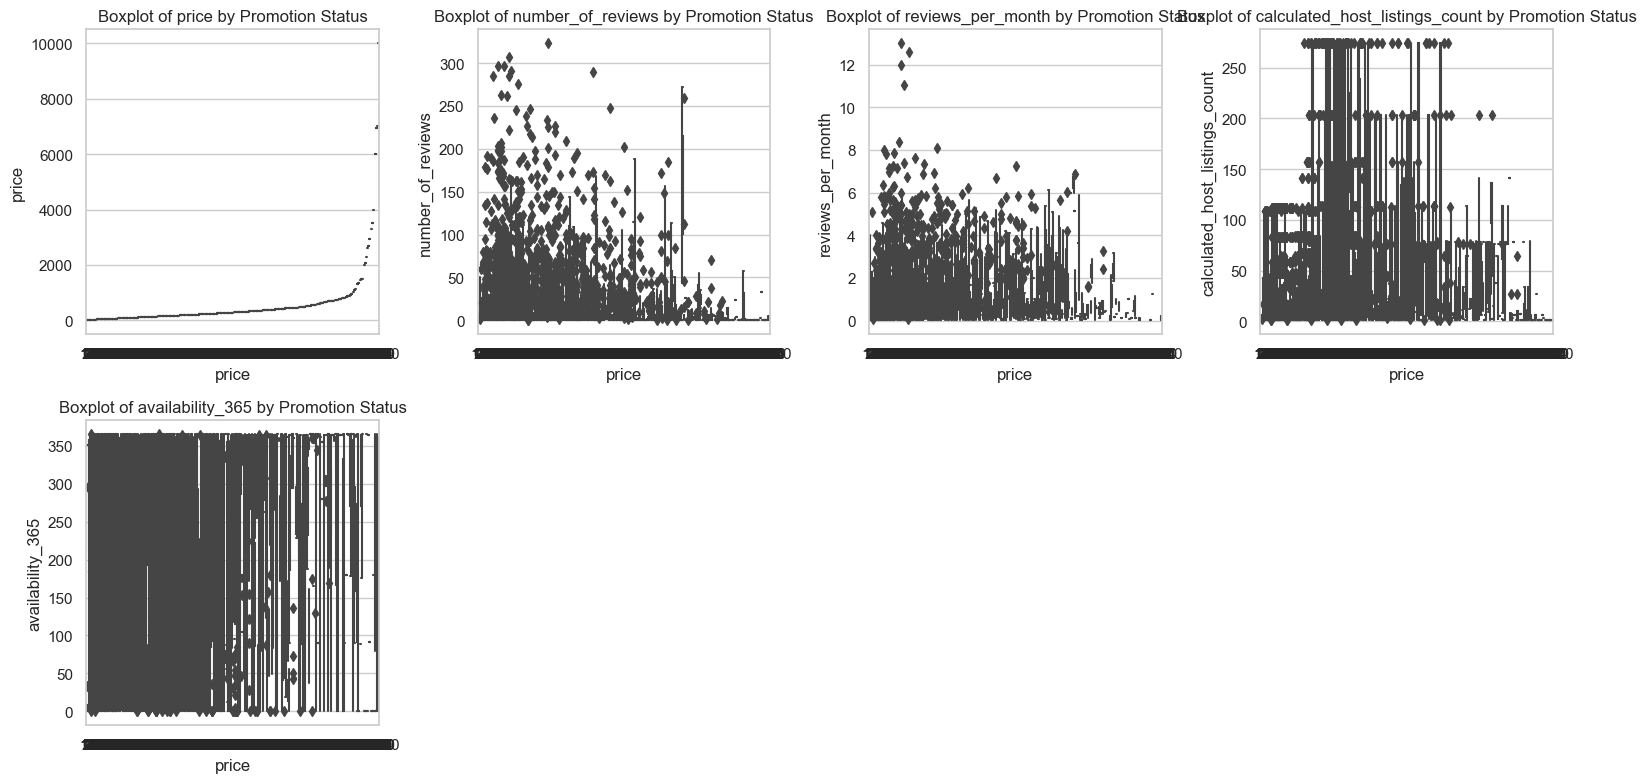

In [33]:
# Set the style for better aesthetics
sns.set(style="whitegrid")

# Select numerical and binary features along with the target variable
features = ['price','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
df_selected_features = df_listings[features]

# Create side-by-side boxplots for numerical features and binary featuresS
plt.figure(figsize=(16, 8))

# Boxplots for numerical features
for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='price', y=feature, data=df_selected_features)
    plt.title(f'Boxplot of {feature} by Promotion Status')

plt.tight_layout()
plt.show()


### 2.2 Cleanse and Transform the data

In [34]:
df_listings.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [35]:
# Check if rows with null values are the same
null_rows_last_review = df_listings[df_listings['last_review'].isnull()]
null_rows_reviews_per_month = df_listings[df_listings['reviews_per_month'].isnull()]

# Check if the rows are the same
rows_are_same = null_rows_last_review.index.equals(null_rows_reviews_per_month.index)

print(f"Are the rows with null values the same between 'last_review' and 'reviews_per_month'? {rows_are_same}")


Are the rows with null values the same between 'last_review' and 'reviews_per_month'? True
Are the rows with null values the same between 'last_review' and 'reviews_per_month'? True


In [36]:
# Cleaning "last_review" Column
df_listings['last_review'].fillna(0, inplace=True)  # Fill missing values with 0

In [37]:
# Cleaning "reviews_per_month" Column
df_listings['reviews_per_month'].fillna(0, inplace=True)  # Fill missing values with 0


In [38]:
df_listings.isnull().sum()

id                                0
name                              2
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

id                                0
name                              2
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#### Outliers

In [39]:
# Assuming df_data is your DataFrame
number_of_reviews_column = df_listings['number_of_reviews']
reviews_per_month_column = df_listings['reviews_per_month']

# Function to calculate outliers
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()

# Count outliers for outliers_count_number_of_reviews
outliers_count_number_of_reviews = count_outliers(number_of_reviews_column)

# Count outliers for reviews_per_month
outliers_count_reviews_per_month = count_outliers(reviews_per_month_column)

# Total number of rows
total_rows = len(df_listings)

# Print the results
print(f"Number of outliers in 'number_of_reviews': {outliers_count_number_of_reviews}")
print(f"Number of outliers in 'reviews_per_month': {outliers_count_reviews_per_month}")
print(f"Total number of rows: {total_rows}")
print(f"Percentage of outliers in 'number_of_reviews': {100 * outliers_count_number_of_reviews / total_rows:.2f}%")
print(f"Percentage of outliers in 'reviews_per_month': {100 * outliers_count_reviews_per_month / total_rows:.2f}%")


Number of outliers in 'number_of_reviews': 1102
Number of outliers in 'reviews_per_month': 806
Total number of rows: 7907
Percentage of outliers in 'number_of_reviews': 13.94%
Percentage of outliers in 'reviews_per_month': 10.19%
Number of outliers in 'number_of_reviews': 1102
Number of outliers in 'reviews_per_month': 806
Total number of rows: 7907
Percentage of outliers in 'number_of_reviews': 13.94%
Percentage of outliers in 'reviews_per_month': 10.19%


In [40]:
number_of_reviews_column = df_listings['number_of_reviews']
reviews_per_month_column = df_listings['reviews_per_month']

# Function to remove outliers
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_listings[(column >= lower_bound) & (column <= upper_bound)]

# Remove outliers for 'number_of_reviews'
df_listings_no_outliers_number_of_reviews = remove_outliers(number_of_reviews_column)

# Remove outliers for 'reviews_per_month'
df_listings_no_outliers_reviews_per_month = remove_outliers(reviews_per_month_column)
df_listings.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,2.338862e+07,9.114481e+07,1.314192,103.848787,169.332996,17.510054,12.807386,0.679632,40.607689,208.726318
std,1.016416e+07,8.190910e+07,0.030577,0.043675,340.187599,42.094616,29.707746,1.150680,65.135253,146.120034
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.582180e+07,2.305808e+07,1.295795,103.835825,65.000000,1.000000,0.000000,0.000000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.000000,0.160000,9.000000,260.000000
75%,3.234850e+07,1.553811e+08,1.322110,103.872535,199.000000,10.000000,10.000000,0.850000,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,2.338862e+07,9.114481e+07,1.314192,103.848787,169.332996,17.510054,12.807386,0.679632,40.607689,208.726318
std,1.016416e+07,8.190910e+07,0.030577,0.043675,340.187599,42.094616,29.707746,1.150680,65.135253,146.120034
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.582180e+07,2.305808e+07,1.295795,103.835825,65.000000,1.000000,0.000000,0.000000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.000000,0.160000,9.000000,260.000000
75%,3.234850e+07,1.553811e+08,1.322110,103.872535,199.000000,10.000000,10.000000,0.850000,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


### 2.3 Correlation Analysis

### 2.2.2 Feature Engineering

#### Drop the irrelevant features/ columns

In [41]:
# Drop the 'id','name','host_id','host_name','calculated_host_listings_count' columns
df_listings = df_listings.drop(['id','name','host_id','host_name','calculated_host_listings_count'], axis = 1)
df_listings.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,365
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,365
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,365
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,353
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,355


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,365
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,365
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,365
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,353
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,355


#### Create New Features

In [42]:
df_listings['average_price_per_night'] = df_listings['price'] / df_listings['minimum_nights']

In [43]:
df_listings['location_popularity_index'] = df_listings['availability_365'] / df_listings['number_of_reviews'] 
df_listings.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,365,0.461111,365.000000
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,365,0.900000,20.277778
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,365,11.500000,18.250000
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,353,206.000000,25.214286
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,355,94.000000,16.136364


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,365,0.461111,365.000000
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,365,0.900000,20.277778
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,365,11.500000,18.250000
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,353,206.000000,25.214286
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,355,94.000000,16.136364


### 2.2.3 Data transformation

#### Encode Categorical Data Columns

In [44]:
unique = df_listings['neighbourhood_group'].unique()
unique

array(['North Region', 'Central Region', 'East Region', 'West Region',
       'North-East Region'], dtype=object)

array(['North Region', 'Central Region', 'East Region', 'West Region',
       'North-East Region'], dtype=object)

In [45]:
unique = df_listings['neighbourhood'].unique()
unique

array(['Woodlands', 'Bukit Timah', 'Tampines', 'Bedok', 'Bukit Merah',
       'Newton', 'Geylang', 'River Valley', 'Jurong West', 'Rochor',
       'Queenstown', 'Serangoon', 'Marine Parade', 'Pasir Ris',
       'Toa Payoh', 'Outram', 'Punggol', 'Tanglin', 'Hougang', 'Kallang',
       'Novena', 'Downtown Core', 'Bukit Panjang', 'Singapore River',
       'Orchard', 'Ang Mo Kio', 'Bukit Batok', 'Museum', 'Sembawang',
       'Choa Chu Kang', 'Central Water Catchment', 'Sengkang', 'Clementi',
       'Jurong East', 'Bishan', 'Yishun', 'Mandai', 'Southern Islands',
       'Sungei Kadut', 'Western Water Catchment', 'Tuas', 'Marina South',
       'Lim Chu Kang'], dtype=object)

array(['Woodlands', 'Bukit Timah', 'Tampines', 'Bedok', 'Bukit Merah',
       'Newton', 'Geylang', 'River Valley', 'Jurong West', 'Rochor',
       'Queenstown', 'Serangoon', 'Marine Parade', 'Pasir Ris',
       'Toa Payoh', 'Outram', 'Punggol', 'Tanglin', 'Hougang', 'Kallang',
       'Novena', 'Downtown Core', 'Bukit Panjang', 'Singapore River',
       'Orchard', 'Ang Mo Kio', 'Bukit Batok', 'Museum', 'Sembawang',
       'Choa Chu Kang', 'Central Water Catchment', 'Sengkang', 'Clementi',
       'Jurong East', 'Bishan', 'Yishun', 'Mandai', 'Southern Islands',
       'Sungei Kadut', 'Western Water Catchment', 'Tuas', 'Marina South',
       'Lim Chu Kang'], dtype=object)

In [46]:
unique = df_listings['room_type'].unique()
unique

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [47]:
# Encoding "neighbourhood_group" column
neighbourhood_group_mapping = {'North Region': 0, 'Central Region': 1, 'East Region': 2, 'West Region': 3, 'North-East Region': 4}
df_listings['neighbourhood_group'] = df_listings['neighbourhood_group'].map(neighbourhood_group_mapping).astype(int)

In [48]:
# Encoding "room_type" column
room_type_mapping = {'Private room': 0, 'Entire home/apt': 1, 'Shared room': 2}
df_listings['room_type'] = df_listings['room_type'].map(room_type_mapping).astype(int)

In [49]:
from datetime import datetime

df_listings['last_review'] = pd.to_datetime(df_listings['last_review'], errors='coerce')

# Calculate the time difference in months and replace the existing 'last_review' column
current_date = datetime.now()
df_listings['last_review'] = ((current_date - df_listings['last_review']) / pd.Timedelta(days=30)).fillna(0).astype(int)

# Display the DataFrame with the updated 'last_review' column in months
df_listings



,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,0,Woodlands,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000
1,1,Bukit Timah,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778
2,0,Woodlands,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000
3,2,Tampines,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286
4,2,Tampines,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,1,Queenstown,1.27973,103.78751,1,100,3,0,0,0.00,61,33.333333,inf
7903,1,Tanglin,1.29269,103.82623,1,550,6,0,0,0.00,365,91.666667,inf
7904,1,Kallang,1.31286,103.85996,0,58,30,0,0,0.00,173,1.933333,inf
7905,1,River Valley,1.29543,103.83801,0,56,14,0,0,0.00,30,4.000000,inf


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,0,Woodlands,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000
1,1,Bukit Timah,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778
2,0,Woodlands,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000
3,2,Tampines,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286
4,2,Tampines,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,1,Queenstown,1.27973,103.78751,1,100,3,0,0,0.00,61,33.333333,inf
7903,1,Tanglin,1.29269,103.82623,1,550,6,0,0,0.00,365,91.666667,inf
7904,1,Kallang,1.31286,103.85996,0,58,30,0,0,0.00,173,1.933333,inf
7905,1,River Valley,1.29543,103.83801,0,56,14,0,0,0.00,30,4.000000,inf


In [50]:
# Create a mapping for encoding
neighbourhood_mapping = {neighbourhood: idx for idx, neighbourhood in enumerate(df_listings['neighbourhood'].unique())}

# Apply the mapping to encode the 'neighbourhood' column
df_listings['neighbourhood'] = df_listings['neighbourhood'].map(neighbourhood_mapping).astype(int)

df_listings.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,0,0,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000
1,1,1,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778
2,0,0,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000
3,2,2,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286
4,2,2,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
0,0,0,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000
1,1,1,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778
2,0,0,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000
3,2,2,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286
4,2,2,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364


array(['Woodlands', 'Bukit Timah', 'Tampines', 'Bedok', 'Bukit Merah',
       'Newton', 'Geylang', 'River Valley', 'Jurong West', 'Rochor',
       'Queenstown', 'Serangoon', 'Marine Parade', 'Pasir Ris',
       'Toa Payoh', 'Outram', 'Punggol', 'Tanglin', 'Hougang', 'Kallang',
       'Novena', 'Downtown Core', 'Bukit Panjang', 'Singapore River',
       'Orchard', 'Ang Mo Kio', 'Bukit Batok', 'Museum', 'Sembawang',
       'Choa Chu Kang', 'Central Water Catchment', 'Sengkang', 'Clementi',
       'Jurong East', 'Bishan', 'Yishun', 'Mandai', 'Southern Islands',
       'Sungei Kadut', 'Western Water Catchment', 'Tuas', 'Marina South',
       'Lim Chu Kang']
       
It goes in sequence, 0 is Woodlands and bukit timah is 1

#### Transform the Numeric Data Columns

In [51]:
df_listings.describe()

C:\Users\tanti\OneDrive - Ngee Ann Polytechnic\Documents\Anaconda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\tanti\OneDrive - Ngee Ann Polytechnic\Documents\Anaconda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7327.000000
mean,1.306311,13.950803,1.314192,103.848787,0.622233,169.332996,17.510054,12.807386,39.530416,0.679632,208.726318,75.789090,inf
std,0.814437,8.499177,0.030577,0.043675,0.578584,340.187599,42.094616,29.707746,30.326609,1.150680,146.120034,246.536902,NaN
min,0.000000,0.000000,1.243870,103.646560,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,1.295795,103.835825,0.000000,65.000000,1.000000,0.000000,0.000000,0.000000,54.000000,11.000000,5.545455
50%,1.000000,14.000000,1.311030,103.849410,1.000000,124.000000,3.000000,2.000000,54.000000,0.160000,260.000000,39.800000,71.600000
75%,1.000000,20.000000,1.322110,103.872535,1.000000,199.000000,10.000000,10.000000,57.000000,0.850000,355.000000,83.333333,NaN
max,4.000000,42.000000,1.454590,103.973420,2.000000,10000.000000,1000.000000,323.000000,124.000000,13.000000,365.000000,10000.000000,inf


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7327.000000
mean,1.306311,13.950803,1.314192,103.848787,0.622233,169.332996,17.510054,12.807386,39.530416,0.679632,208.726318,75.789090,inf
std,0.814437,8.499177,0.030577,0.043675,0.578584,340.187599,42.094616,29.707746,30.326609,1.150680,146.120034,246.536902,NaN
min,0.000000,0.000000,1.243870,103.646560,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,1.295795,103.835825,0.000000,65.000000,1.000000,0.000000,0.000000,0.000000,54.000000,11.000000,5.545455
50%,1.000000,14.000000,1.311030,103.849410,1.000000,124.000000,3.000000,2.000000,54.000000,0.160000,260.000000,39.800000,71.600000
75%,1.000000,20.000000,1.322110,103.872535,1.000000,199.000000,10.000000,10.000000,57.000000,0.850000,355.000000,83.333333,NaN
max,4.000000,42.000000,1.454590,103.973420,2.000000,10000.000000,1000.000000,323.000000,124.000000,13.000000,365.000000,10000.000000,inf


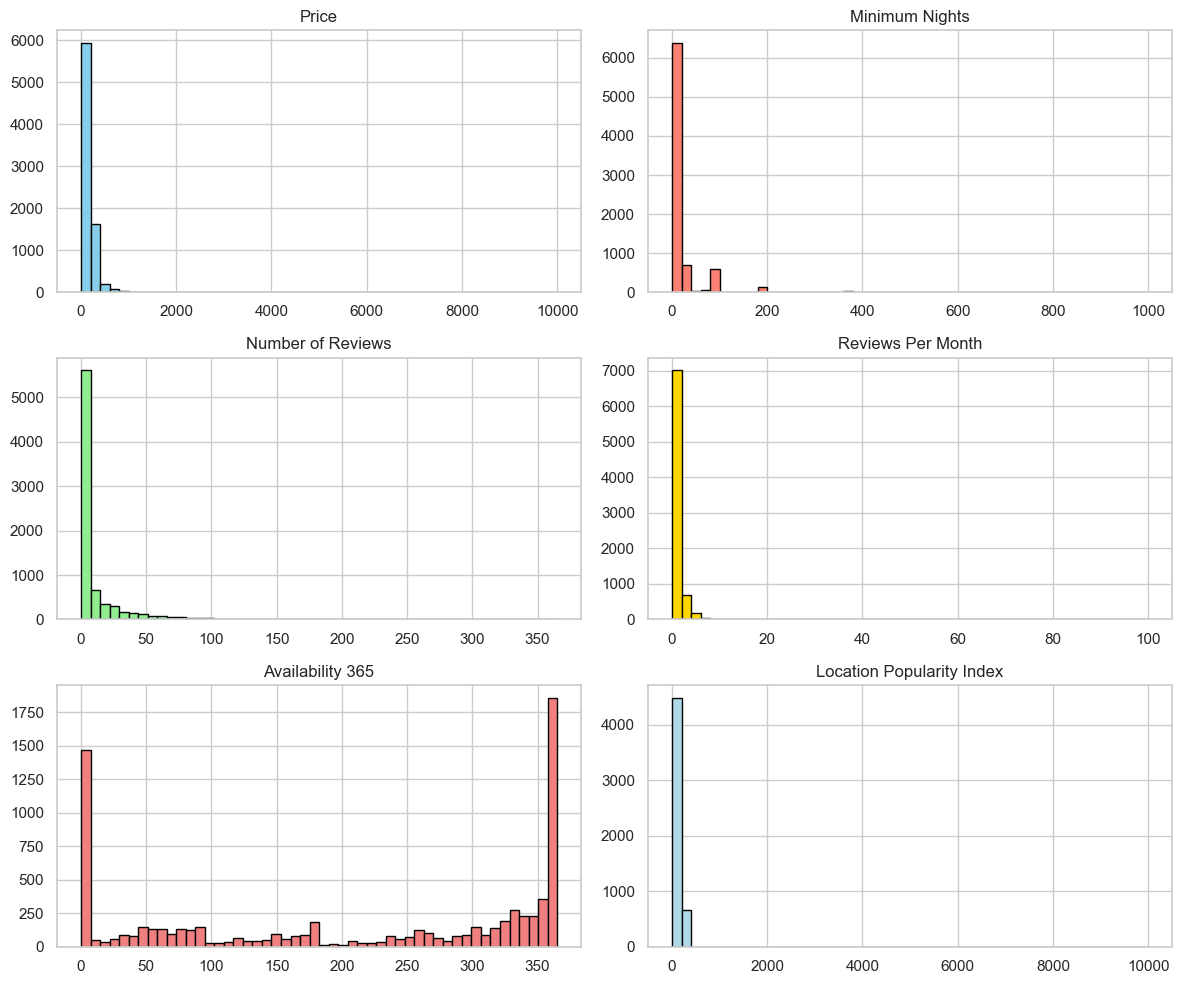

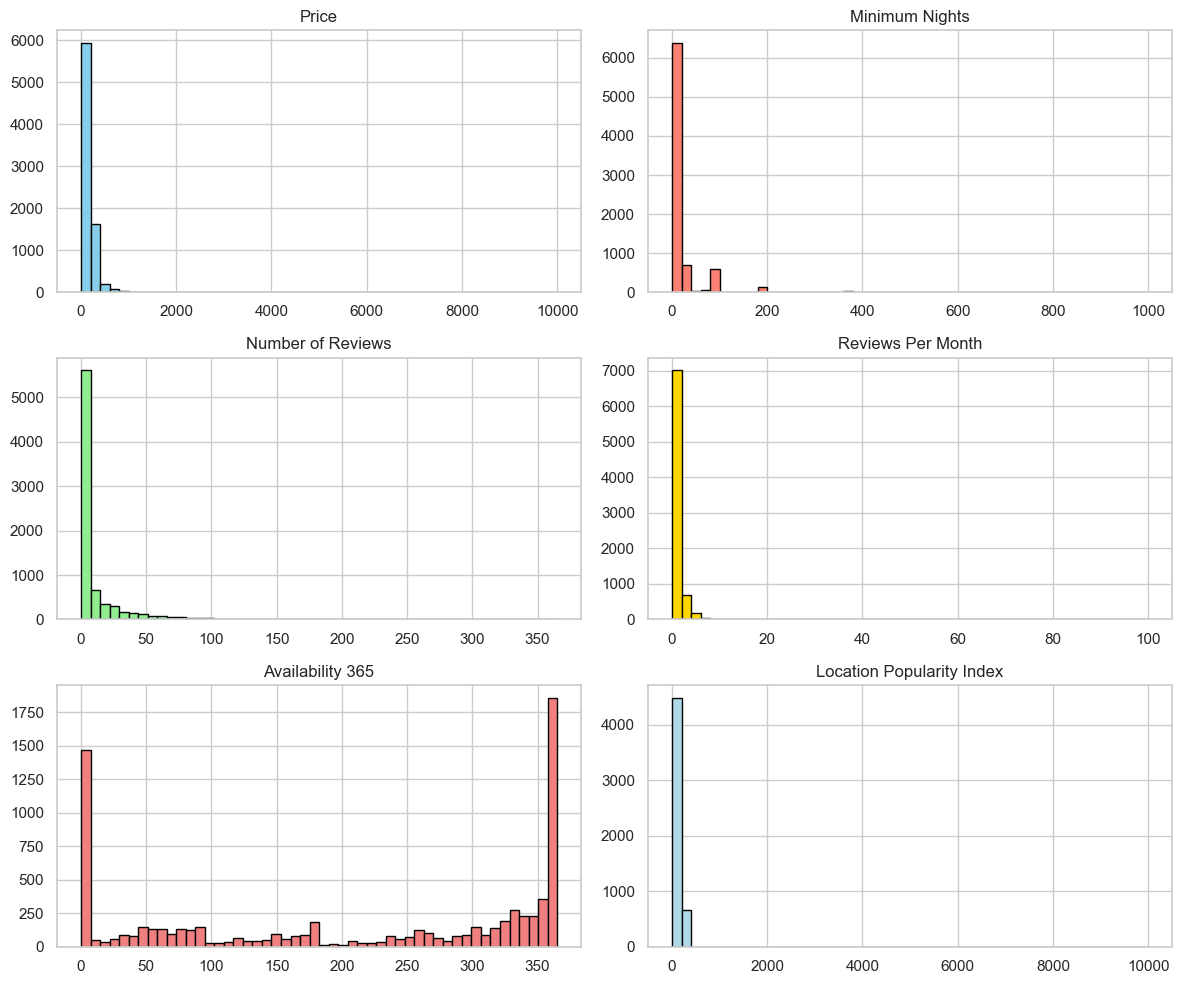

In [52]:
# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Price
axes[0, 0].hist(df_listings['price'], bins=50, range=(0, 10000), color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price')

# Minimum Nights
axes[0, 1].hist(df_listings['minimum_nights'], bins=50, range=(0, 1000), color='salmon', edgecolor='black')
axes[0, 1].set_title('Minimum Nights')

# Number of Reviews
axes[1, 0].hist(df_listings['number_of_reviews'], bins=50,range=(0, 365), color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Number of Reviews')

# Reviews Per Month
axes[1, 1].hist(df_listings['reviews_per_month'], bins=50,range=(0, 100), color='gold', edgecolor='black')
axes[1, 1].set_title('Reviews Per Month')

# Availability 365
axes[2, 0].hist(df_listings['availability_365'], bins=50,range=(0, 365), color='lightcoral', edgecolor='black')
axes[2, 0].set_title('Availability 365')

# Location Popularity Index
axes[2, 1].hist(df_listings['location_popularity_index'], bins=50,range=(0, 10000), color='lightblue', edgecolor='black')
axes[2, 1].set_title('Location Popularity Index')

# Adjust layout
plt.tight_layout()
plt.show()


In [53]:
# Bin / Group location_popularity_index values
df_listings.loc[df_listings['location_popularity_index'] <= 122, 'popularity_level'] = 0
df_listings.loc[(df_listings['location_popularity_index'] > 122) & (df_listings['location_popularity_index'] <= 244), 'popularity_level'] = 1
df_listings.loc[df_listings['location_popularity_index'] > 244, 'popularity_level'] = 2

# Cleaning "reviews_per_month" Column
df_listings['location_popularity_index'].fillna(3, inplace=True)  # Fill missing values with 3
df_listings['popularity_level'] = df_listings['popularity_level'].astype(float)  # Change to float type

# Convert the new column to integer type, treating NaN and inf as 3
df_listings['popularity_level'] = df_listings['popularity_level'].fillna(3).astype(int)


- **Comprehensive Popularity Measure:** The index considers both total reviews and availability, providing a holistic measure of a listing's popularity.
- **Normalized Representation:** Normalizing the index to availability ensures fair comparisons among listings with varying levels of accessibility.
- **Quantitative Indicator:** Assigning numeric values (0, 1, 2) enhances interpretability, making it suitable for statistical analyses and machine learning models.
- **Facilitates Decision-Making:** Useful for hosts and travelers alike, the index aids in assessing demand and popularity for informed decision-making.
- **Simplified Analysis:** Numeric values streamline subsequent analytical tasks, making the dataset suitable for various data science applications.

In [54]:
df_listings.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index,popularity_level
0,0,0,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000,2
1,1,1,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778,0
2,0,0,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000,0
3,2,2,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286,0
4,2,2,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364,0


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,average_price_per_night,location_popularity_index,popularity_level
0,0,0,1.44255,103.79580,0,83,180,1,124,0.01,365,0.461111,365.000000,2
1,1,1,1.33235,103.78521,0,81,90,18,110,0.28,365,0.900000,20.277778,0
2,0,0,1.44246,103.79667,0,69,6,20,101,0.20,365,11.500000,18.250000,0
3,2,2,1.34541,103.95712,0,206,1,14,54,0.15,353,206.000000,25.214286,0
4,2,2,1.34567,103.95963,0,94,1,22,54,0.22,355,94.000000,16.136364,0


In [55]:
popularity_counts = df_listings['popularity_level'].value_counts()
print(popularity_counts)


popularity_level
0    4133
2    2807
3     580
1     387
Name: count, dtype: int64
popularity_level
0    4133
2    2807
3     580
1     387
Name: count, dtype: int64


### 2.3 Correlation Analysis

In [56]:
correlation_matrix = df_listings.corr()
correlation_with_target = correlation_matrix['price'].sort_values(ascending=False)
correlation_with_target

price                        1.000000
average_price_per_night      0.859689
room_type                    0.100629
neighbourhood                0.065002
popularity_level             0.062691
availability_365             0.017451
location_popularity_index   -0.003895
minimum_nights              -0.012214
neighbourhood_group         -0.030426
longitude                   -0.030436
reviews_per_month           -0.030822
number_of_reviews           -0.042013
last_review                 -0.068321
latitude                    -0.073990
Name: price, dtype: float64

price                        1.000000
average_price_per_night      0.859689
room_type                    0.100629
neighbourhood                0.065002
popularity_level             0.062691
availability_365             0.017451
location_popularity_index   -0.003895
minimum_nights              -0.012214
neighbourhood_group         -0.030426
longitude                   -0.030436
reviews_per_month           -0.030822
number_of_reviews           -0.042013
last_review                 -0.068321
latitude                    -0.073990
Name: price, dtype: float64

In [57]:
df_northregion = df_listings[df_listings['neighbourhood_group'] == 0]
df_centralregion = df_listings[df_listings['neighbourhood_group'] == 1]
df_eastregion = df_listings[df_listings['neighbourhood_group'] == 2]
df_westregion = df_listings[df_listings['neighbourhood_group'] == 3]
df_northeastregion = df_listings[df_listings['neighbourhood_group'] == 4]

In [58]:
# Drop the weak correlation columns
df_listings = df_listings.drop(['availability_365','location_popularity_index','minimum_nights','reviews_per_month','longitude','number_of_reviews','latitude','last_review','neighbourhood_group'], axis = 1)
df_listings.head()

,neighbourhood,room_type,price,average_price_per_night,popularity_level
0,0,0,83,0.461111,2
1,1,0,81,0.900000,0
2,0,0,69,11.500000,0
3,2,0,206,206.000000,0
4,2,0,94,94.000000,0


,neighbourhood,room_type,price,average_price_per_night,popularity_level
0,0,0,83,0.461111,2
1,1,0,81,0.900000,0
2,0,0,69,11.500000,0
3,2,0,206,206.000000,0
4,2,0,94,94.000000,0


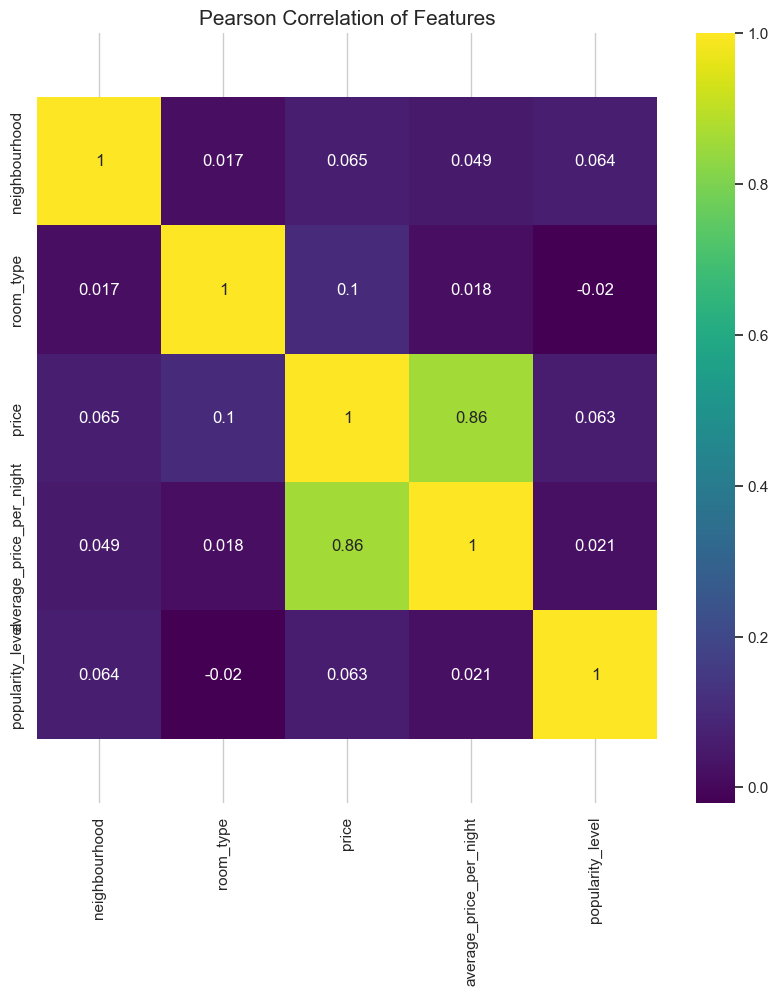

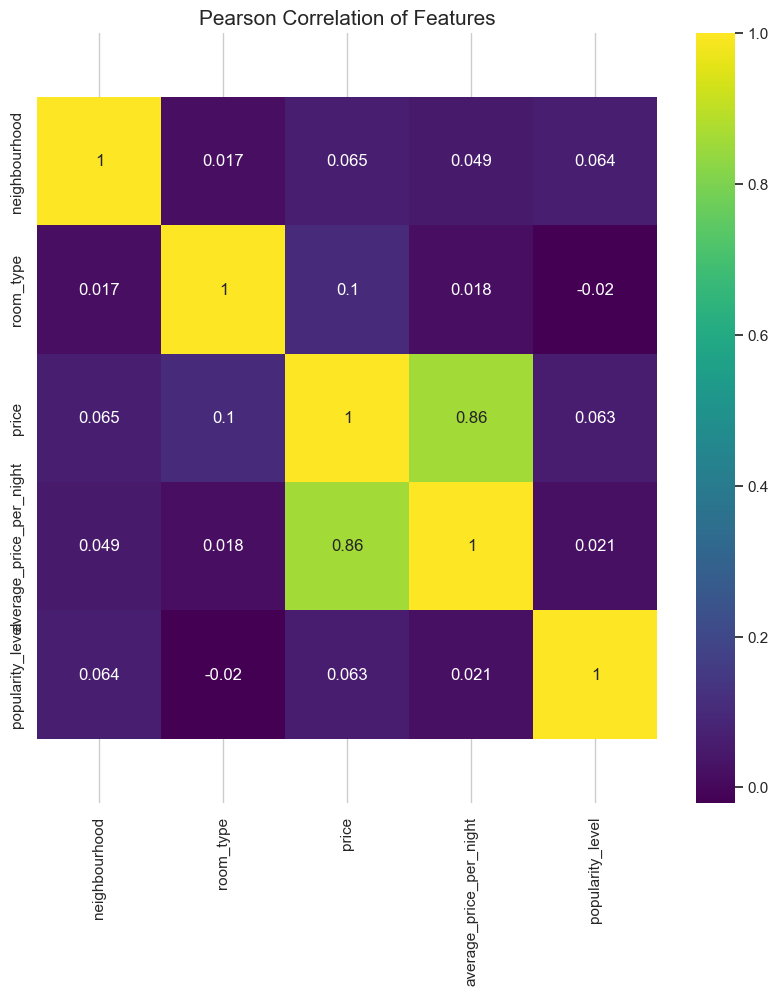

In [59]:
# Heatmap: the correlation between any two features/variables
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(df_listings.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [60]:
# # Set relevant columns for the scatter matrix
# selected_columns = ['price', 'neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'average_price_per_night', 'location_popularity_index', 'popularity_level']

# # Set style
# sns.set(style="ticks")

# # Create a scatter matrix
# scatter_matrix = sns.pairplot(df_listings[selected_columns], hue='popularity_level', markers=["o", "s"], palette="husl")
# plt.suptitle("Scatter Matrix for Selected Columns", y=1.02, size=16)
# plt.show()


### 2.4 Export the data

In [61]:
df_listings.to_csv('listings_new.csv', index=False)